# Assignment #1: Sequence Labeling
## Natural Language Processing
### Alberto Luise, Angelo Quarta, Edoardo Fusa

In [1]:
import pathlib
import pandas as pd
import numpy as np
import urllib
import zipfile
import os
import collections
import string
import matplotlib.pyplot as plt
import random
import pickle
import itertools
from wordcloud import WordCloud

import POS_utility
import importlib

C:\Users\Alber\anaconda3\envs\Boonolis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Alber\anaconda3\envs\Boonolis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\Alber\anaconda3\envs\Boonolis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


The first step is obviously to download and prepare the dataset; we'll first verify if we have already downloaded the files, and if not we'll request them and unzip them. After that, we'll build a Dataframe containing all available samples, dividing them in Training, validation & Test sets.

In [2]:
Data_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
Dataset = Data_url.split("/")[-1].split(".")[0]
print(f"Download folder: {pathlib.Path.cwd()}")
dataset_folder = pathlib.Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)
if not dataset_folder.joinpath(Dataset).exists():
    filename = dataset_folder.joinpath("Assignment_Dataset.zip")
    urllib.request.urlretrieve(url=Data_url, filename=filename)
    print("Download finished! Extracting...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

Download folder: C:\Users\Alber\Documents\Notebooks\Assignment_1


In [3]:
rows = []
raw_data_folder = dataset_folder.joinpath(Dataset)
for r, set in [(range(1, 101), "train"), (range(101, 151), "val"), (range(151, 200), "test")]:
    for i in r:
        f = open(raw_data_folder.joinpath("wsj_" + str(i).zfill(4) + ".dp"),  "r")
        for line in f.readlines():
            if line != "\n":
                (word, pos, _) = line.split()
                dataframe_row = {
                            "Sentence_ID": i,
                            "set": set,
                            "text": word,
                            "POS": pos
                        }
                rows.append(dataframe_row)
        f.close()

In [4]:
df_folder = dataset_folder.joinpath("Dataframe")
if not df_folder.exists():
    df_folder.mkdir(parents=True)
df = pd.DataFrame(rows)
df = df[["Sentence_ID", 
         "set",
         "text",
         "POS"]]
df_path = df_folder.joinpath(Dataset).with_name(Dataset + ".pkl")
df.to_pickle(df_path)

In [5]:
print("Complete Dataframe:")
print(df)
print()

print("Distribution of POS: ")
print(df['POS'].value_counts())
print()

print("Distribution of splits: ")
print(df['set'].value_counts())
print()

Complete Dataframe:
       Sentence_ID    set     text  POS
0                1  train   Pierre  NNP
1                1  train   Vinken  NNP
2                1  train        ,    ,
3                1  train       61   CD
4                1  train    years  NNS
...            ...    ...      ...  ...
94079          199   test  quarter   NN
94080          199   test       of   IN
94081          199   test     next   JJ
94082          199   test     year   NN
94083          199   test        .    .

[94084 rows x 4 columns]

Distribution of POS: 
POS
NN       13166
IN        9857
NNP       9410
DT        8165
NNS       6047
JJ        5834
,         4886
.         3874
CD        3546
VBD       3043
RB        2822
VB        2554
CC        2265
TO        2179
VBN       2134
VBZ       2125
PRP       1716
VBG       1460
VBP       1321
MD         927
POS        824
PRP$       766
$          724
``         712
''         694
:          563
WDT        445
JJR        381
NNPS       244
WP         2

#### The POS column has some values (FW, UH, SYM) that are extremely rare, appearing only a single-digit number of times in 94k examples. These could reveal to be really hard to learn & recognize.

Since our machine only understands numbers, we have to embed the words before using them as input data. We'll use GloVe Embedding (Global Vectors), an unsupervised algorithm based on co-occurrence statistics from a specific corpus.

### Step 1: Creating a Vocabulary

In [6]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()
# mask = df['text'].apply(POS_utility.exclude_symbols)
# df = df[mask]
# ...would this go against "do not delete any tokens"?

In [7]:
def build_vocabulary(df: pd.DataFrame):
    """
    Function defining a vocabulary, returning both an 'Index-to-Word' version and a 'Word-to-Index' version.
    Done temporarily to test everything, could be improved or cleaned up.
    """
    Index_to_Word = collections.OrderedDict()
    Word_to_Index = collections.OrderedDict()
    
    idx = 0
    for token in df['text'].unique():
        if token not in Word_to_Index:
            Word_to_Index[token] = idx
            Index_to_Word[idx] = token
            idx += 1

    return Index_to_Word, Word_to_Index
# Do I leave it in main or put it into utility?

idx_to_word, word_to_idx = build_vocabulary(df[df['set'] == 'train'])
print(f'Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'Some words: {[(idx_to_word[idx], idx) for idx in np.arange(8)]}')

Index -> Word vocabulary size: 7404
Some words: [('pierre', 0), ('vinken', 1), (',', 2), ('61', 3), ('years', 4), ('old', 5), ('will', 6), ('join', 7)]


In [8]:
# Optional: save the vocabulary to a JSON for manual checking
SAVE_VOC = False # True

if SAVE_VOC:
    import simplejson as sj

    vocab_path = pathlib.Path.cwd().joinpath('Datasets', 'Vocabulary.json')

    print(f"Saving vocabulary to {vocab_path}")
    with vocab_path.open(mode='w') as f:
        sj.dump(word_to_idx, f, indent=4)
    print("Saving completed!")

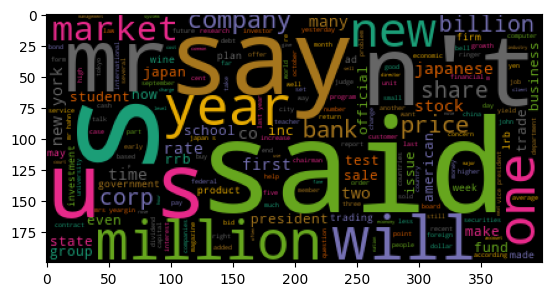

In [9]:
# A bit of visualization

q_S = ' '.join(df[df['set']=='train']['text'])
wordcloud_S = WordCloud(max_font_size=None,scale = 1,colormap = 'Dark2').generate(q_S)
plt.imshow(wordcloud_S)

### Step 2: Applying Embeddings

In [10]:
from keras import preprocessing

tokenizer = preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

glove_folder = pathlib.Path.cwd().joinpath("GloVe")
if not glove_folder.exists():
    glove_folder.mkdir(parents=True)
    filename_2 = glove_folder.joinpath("GloVe.zip")
    urllib.request.urlretrieve(url='http://nlp.stanford.edu/data/glove.6B.zip', filename=filename_2)
    print("Download finished! Extracting...")
    with zipfile.ZipFile(filename_2, 'r') as zip_ref:
        zip_ref.extractall(glove_folder)

embedding_dim = 100
embedding_matrix_vocab = POS_utility.embedding_for_vocab( 
    glove_folder.joinpath(f'glove.6B.{embedding_dim}d.txt'), tokenizer.word_index, 
  embedding_dim) 
  
print("Dense vector for first word is =>", embedding_matrix_vocab[1]) 
print("Total tokens:", len(embedding_matrix_vocab)-1)


Found 10947 unique tokens.
Dense vector for first word is => [-0.10767     0.11053     0.59811997 -0.54360998  0.67395997  0.10663
  0.038867    0.35481     0.06351    -0.094189    0.15786    -0.81664997
  0.14172     0.21939     0.58504999 -0.52157998  0.22782999 -0.16642
 -0.68228     0.35870001  0.42568001  0.19021     0.91962999  0.57555002
  0.46184999  0.42363    -0.095399   -0.42749    -0.16566999 -0.056842
 -0.29595     0.26036999 -0.26605999 -0.070404   -0.27662     0.15820999
  0.69825     0.43081     0.27952    -0.45436999 -0.33801001 -0.58183998
  0.22363999 -0.57779998 -0.26862001 -0.20424999  0.56393999 -0.58524001
 -0.14365    -0.64218003  0.0054697  -0.35247999  0.16162001  1.1796
 -0.47674    -2.75530005 -0.1321     -0.047729    1.06550002  1.10339999
 -0.2208      0.18669     0.13177     0.15117     0.71310002 -0.35214999
  0.91347998  0.61782998  0.70991999  0.23954999 -0.14571001 -0.37858999
 -0.045959   -0.47367999  0.2385      0.20536    -0.18996     0.32506999
 -

In [11]:
OOV = df[~df['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]]).apply(any)]['text']
print("OOV words: ", len(OOV), "   ","Total words in dataset:", len(df['text']))
print("Some OOV words:", OOV.unique()[0:5])

OOV words:  1333     Total words in dataset: 94084
Some OOV words: ['vinken' 'crocidolite' 'micronite' 'amphobiles' 'pathlogy']


The Out-Of-Vocabulary words are mostly last names, technical terms or typos, which is to be expected. These words are encoded as a row of 0s.

That being said, only 1,5% of the dataset is OOV, so it should not be a huge issue to train only on meaningful vectors.

## Model Definition
### Let's start from a baseline model and build something more powerful from there; we'll be using mainyl LSTMs and Dense layers. Before that, however, we'll define our Training and Validation sets.

In [12]:
train_df = df[df['set']=='train']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
oov_mask = train_df.apply(any)
train_df = train_df[oov_mask]
train_X = np.stack(train_df.to_numpy()).astype('float32')

OOV_embed = np.mean(train_X, axis=0)
val_embed = df[df['set']=='val']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in val_embed.index[~val_embed.apply(any)]:
    val_embed[i] = OOV_embed  # Using a static embedding for OOV words
val_X = np.stack(val_embed.to_numpy()).astype('float32')

train_y = df[df['set']=='train']['POS'][oov_mask].to_numpy()
val_y = df[df['set']=='val']['POS'].to_numpy()

print("Input data:",train_X.shape, type(train_X), type(train_X[0][0]))
print("Labels:",train_y.shape, type(train_y), type(train_y[0]))

from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()
encoder.fit(df['POS'])
train_y = encoder.transform(train_y)
val_y = encoder.transform(val_y)

Input data: (46729, 100) <class 'numpy.ndarray'> <class 'numpy.float32'>
Labels: (46729,) <class 'numpy.ndarray'> <class 'str'>


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Masking, Concatenate, Input

BASE_LSTM = 100
baseline_model = POS_utility.build_base_model(BASE_LSTM, len(df['POS'].unique()), "baseline_model")
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 45)                9045      
                                                                 
Total params: 90,645
Trainable params: 90,645
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_1 = POS_utility.build_base_model(BASE_LSTM, len(df['POS'].unique()), "additional_LSTM_model",
                           [Bidirectional(LSTM(BASE_LSTM * 2, return_sequences=False))], return_seq=True)
model_1.summary()

Model: "additional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 100, 200)         81600     
 nal)                                                            
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              641600    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 45)                18045     
                                                                 
Total params: 741,245
Trainable params: 741,245
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_2 = POS_utility.build_base_model(BASE_LSTM, len(df['POS'].unique()), "additional_LSTM_model",
                           [Dense(512, activation='relu')])
model_2.summary()

Model: "additional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 200)              81600     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 512)               102912    
                                                                 
 dense_3 (Dense)             (None, 45)                23085     
                                                                 
Total params: 207,597
Trainable params: 207,597
Non-trainable params: 0
_________________________________________________________________


### Now we'll define a Metric function to evaluate accuracy and quality of the results of our models

In [16]:
def macro_F1_score(y_pred, y_true):
    scores = {}
    for cl in np.unique(np.concatenate((y_pred, y_true))):
        TP = 0
        FP = 0
        FN = 0
        if all(c in string.punctuation for c in encoder.inverse_transform([cl])):
            continue

        for i in range(len(y_pred)):
            if y_pred[i] == cl:
                if y_true[i] == cl:
                    TP += 1
                else:
                    FP += 1
            elif y_true[i] == cl:
                FN += 1

        f1 = TP / (TP + (FP + FN)/2)
        scores[cl] = f1
    return {"Macro_F1": sum(scores.values())/len(scores.values()), "Scores": scores}

print(macro_F1_score([1,2,3,4,5], [1,2,4,4,5]))


{'Macro_F1': 0.8888888888888888, 'Scores': {2: 1.0, 4: 0.6666666666666666, 5: 1.0}}


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Training!

In [18]:
# importlib.reload(POS_utility)
ckp_folder = pathlib.Path.cwd().joinpath("Checkpoints")
if not ckp_folder.exists():
    ckp_folder.mkdir(parents=True)
random_seeds = ["42", "1337", "1968"]
DO_TRAINING = True

if DO_TRAINING:
    baseline_hist = POS_utility.impermanent_training(
        baseline_model, ckp_folder.joinpath('baseline'), train_X, train_y, val_X, val_y, seeds=random_seeds)
    with open(ckp_folder.joinpath('baselineHistoryDict'), 'wb') as file_pi:
        pickle.dump(baseline_hist, file_pi)
else:
    with open(ckp_folder.joinpath('baselineHistoryDict'), "rb") as file_pi:
        baseline_hist = pickle.load(file_pi)

Beginning training 1/3
Epoch 1/10
731/731 [==============================] - 25s 28ms/step - loss: 2.0648 - accuracy: 0.4192 - val_loss: 1.4326 - val_accuracy: 0.5910
Epoch 2/10
731/731 [==============================] - 20s 28ms/step - loss: 1.1702 - accuracy: 0.6460 - val_loss: 1.1667 - val_accuracy: 0.6540
Epoch 3/10
731/731 [==============================] - 21s 28ms/step - loss: 0.9696 - accuracy: 0.7004 - val_loss: 1.0589 - val_accuracy: 0.6868
Epoch 4/10
731/731 [==============================] - 21s 28ms/step - loss: 0.8700 - accuracy: 0.7276 - val_loss: 0.9807 - val_accuracy: 0.7155
Epoch 5/10
731/731 [==============================] - 20s 27ms/step - loss: 0.7817 - accuracy: 0.7539 - val_loss: 0.9171 - val_accuracy: 0.7273
Epoch 6/10
731/731 [==============================] - 20s 28ms/step - loss: 0.7190 - accuracy: 0.7733 - val_loss: 0.8928 - val_accuracy: 0.7375
Epoch 7/10
731/731 [==============================] - 20s 28ms/step - loss: 0.6713 - accuracy: 0.7899 - val_loss:

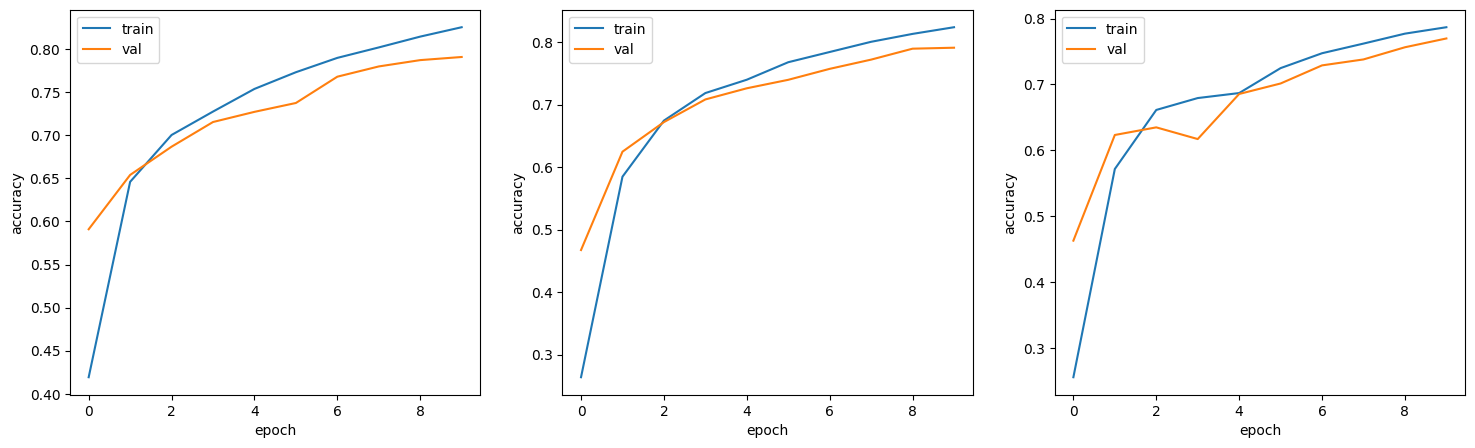

In [19]:
POS_utility.plot_single_runs(baseline_hist)

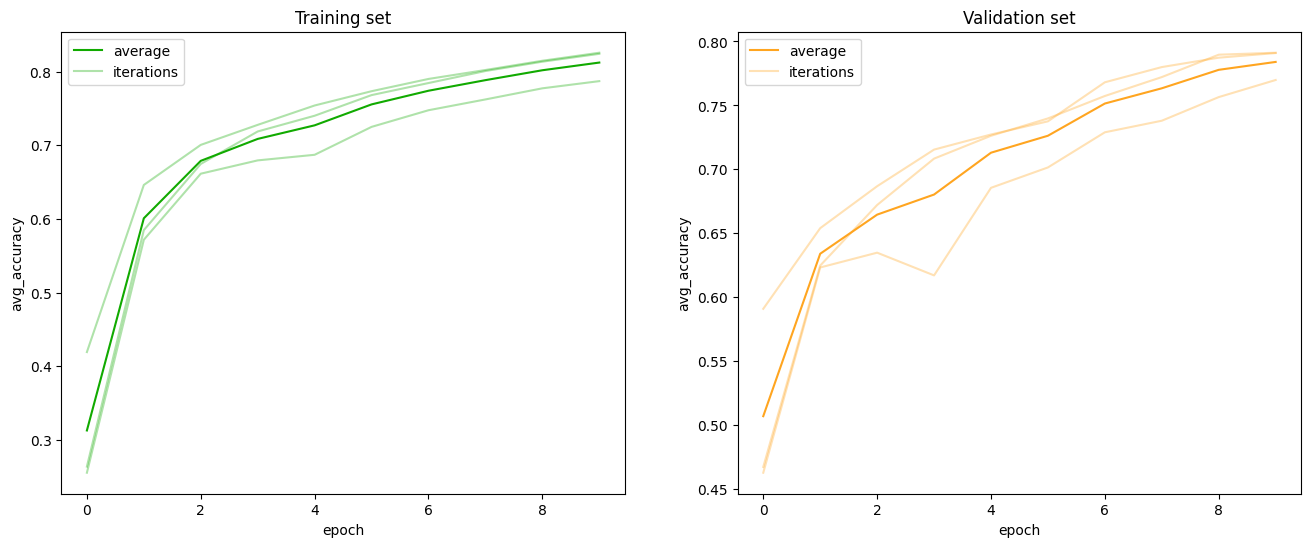

In [20]:
POS_utility.plot_averages(baseline_hist)

In [21]:
test_embed = df[df['set']=='test']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in test_embed.index[~test_embed.apply(any)]:
    test_embed[i] = OOV_embed  # Using a static embedding for OOV words
test_X = np.stack(test_embed.to_numpy()).astype('float32')
test_y = df[df['set']=='test']['POS'].to_numpy()
test_y = encoder.transform(test_y)

In [25]:
# importlib.reload(POS_utility)
scores_dicts = POS_utility.evaluate_model(baseline_model, ckp_folder.joinpath('baseline'),
                                          test_X, test_y, macro_F1_score, len(random_seeds))
print("Average Macro F1 Score = ", np.mean([x["Macro_F1"] for x in scores_dicts]))
print(POS_utility.errors_summary(scores_dicts, encoder, train_y, test_y))

Testing model n.1
486/486 - 4s - 4s/epoch - 8ms/step
Testing model n.2
486/486 - 4s - 4s/epoch - 8ms/step
Testing model n.3
486/486 - 4s - 4s/epoch - 8ms/step
Average Macro F1 Score =  0.6834475607398276
  POS class train count test count     score
0     -LRB-           0         18       0.0
1     -RRB-           0         18       0.0
2      NNPS          95         44       0.0
3       PDT           9          4       0.0
4       RBR          86         15   0.47619
5       RBS          19          3       0.4
6        RP         140         33      0.48
7       VBN        1031        366  0.418919


In [26]:
pd.options.mode.chained_assignment = None 

df_seq_train_X = df[df['set']=='train'][oov_mask].groupby(['Sentence_ID'])['text'].apply(' '.join).reset_index()
df_seq_train_X['text'] = df_seq_train_X['text'].apply(str.split)
df_seq_train_X['text'] = df_seq_train_X['text'].apply(lambda x: [embedding_matrix_vocab[word_index[j]] for j in x])
print("Training set encodings:")
print(df_seq_train_X.head())

df_seq_train_Y = df[df['set']=='train'][oov_mask].groupby(['Sentence_ID'])['POS'].apply(' '.join).reset_index()
df_seq_train_Y['POS'] = df_seq_train_Y['POS'].apply(str.split)
print("Training set POS:")
print(df_seq_train_Y.head())

val_embed = df[['Sentence_ID','text']][df['set']=='val'].copy(deep=True)
val_embed['text'] = val_embed['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in val_embed.index[~val_embed['text'].apply(any)]:
    val_embed['text'][i] = OOV_embed  # Using a static embedding for OOV words

df_seq_val_X = val_embed.groupby(['Sentence_ID'])['text'].apply(lambda x: [x]).reset_index()
df_seq_val_X['text'] = df_seq_val_X['text'].apply(np.squeeze)
df_seq_val_Y = df[df['set']=='val'].groupby(['Sentence_ID'])['POS'].apply(' '.join).reset_index()
df_seq_val_Y['POS'] = df_seq_val_Y['POS'].apply(str.split)
print("Validation set encodings:")
print(df_seq_val_X.head())
print("Validation set POS:")
print(df_seq_val_Y.head())

Training set encodings:
   Sentence_ID                                               text
0            1  [[-0.42798998951911926, -0.4792400002479553, -...
1            2  [[0.4851300120353699, 0.2844200134277344, -0.1...
2            3  [[-0.2708599865436554, 0.04400600120425224, -0...
3            4  [[0.1277800053358078, 0.4896000027656555, 0.45...
4            5  [[0.07251100242137909, -0.1062299981713295, -0...
Training set POS:
   Sentence_ID                                                POS
0            1  [NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, IN, D...
1            2  [NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...
2            3  [DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...
3            4  [NNS, IN, JJ, NNS, VBD, TO, VB, ,, IN, NNS, IN...
4            5  [NNP, NNP, ,, NN, NN, IN, NNP, NNP, CC, NNP, ,...
Validation set encodings:
   Sentence_ID                                               text
0          101  [[-0.2708599865436554, 0.04400600120425224, -0...
1       

In [48]:
seq_train_X = df_seq_train_X['text'].apply(lambda x: np.stack(np.array(x)))
print("Training set shape:")
print(type(seq_train_X),type(seq_train_X[0]),type(seq_train_X[0][0]),type(seq_train_X[0][0][0]))
seq_train_y = df_seq_train_Y['POS'].apply(lambda x: np.array(encoder.transform(x)).astype(float))
print("Training labels:")
print(type(seq_train_y),type(seq_train_y[0]),type(seq_train_y[0][0]))

seq_val_X = df_seq_val_X['text'].apply(lambda x: np.stack(np.array(x)))
seq_val_y = df_seq_val_Y['POS'].apply(lambda x: np.array(encoder.transform(x)).astype(float))

importlib.reload(POS_utility)
seq_train_X = POS_utility.pad_sentences(seq_train_X, embedding_dim, 'train')
seq_val_X = POS_utility.pad_sentences(seq_val_X, embedding_dim, 'val')
seq_train_y = np.column_stack((itertools.zip_longest(*seq_train_y, fillvalue=0.)))
seq_val_y = np.column_stack((itertools.zip_longest(*seq_val_y, fillvalue=0.)))

Training set shape:
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
Training labels:
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.float64'>
Final Shape for train:
(100, 2841, 100)
Final Shape for val:
(50, 4534, 100)


In [49]:
seq_baseline = POS_utility.build_seq_model(BASE_LSTM, len(df['POS'].unique()), "baseline_seq_model")
seq_baseline.summary()

Model: "baseline_seq_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 100)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, None, 45)         9045      
 tributed)                                                       
                                                                 
Total params: 169,845
Trainable params: 169,845
Non-trainable params: 0
_________________________________________________________________


In [51]:
if DO_TRAINING:
    seq_baseline_hist = POS_utility.impermanent_training(
        seq_baseline, ckp_folder.joinpath('seq_baseline'), seq_train_X, seq_train_y,
        seq_val_X, seq_val_y,seeds=random_seeds, batch_size=1)
    with open(ckp_folder.joinpath('seqHistoryDict'), 'wb') as file_pi:
        pickle.dump(seq_baseline_hist, file_pi)
else:
    with open(ckp_folder.joinpath('seqHistoryDict'), "rb") as file_pi:
        seq_baseline_hist = pickle.load(file_pi)

Beginning training 1/3
Epoch 1/10
100/100 [==============================] - 13s 86ms/step - loss: 0.4274 - accuracy: 0.3449 - val_loss: 0.2470 - val_accuracy: 0.5797
Epoch 2/10
100/100 [==============================] - 7s 73ms/step - loss: 0.2133 - accuracy: 0.6872 - val_loss: 0.1407 - val_accuracy: 0.7475
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.1337 - accuracy: 0.7971 - val_loss: 0.1046 - val_accuracy: 0.8082
Epoch 4/10
100/100 [==============================] - 7s 73ms/step - loss: 0.1019 - accuracy: 0.8416 - val_loss: 0.0879 - val_accuracy: 0.8356
Epoch 5/10
100/100 [==============================] - 7s 74ms/step - loss: 0.0859 - accuracy: 0.8630 - val_loss: 0.0771 - val_accuracy: 0.8542
Epoch 6/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0744 - accuracy: 0.8802 - val_loss: 0.0709 - val_accuracy: 0.8653
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0677 - accuracy: 0.8896 - val_loss: 0.065

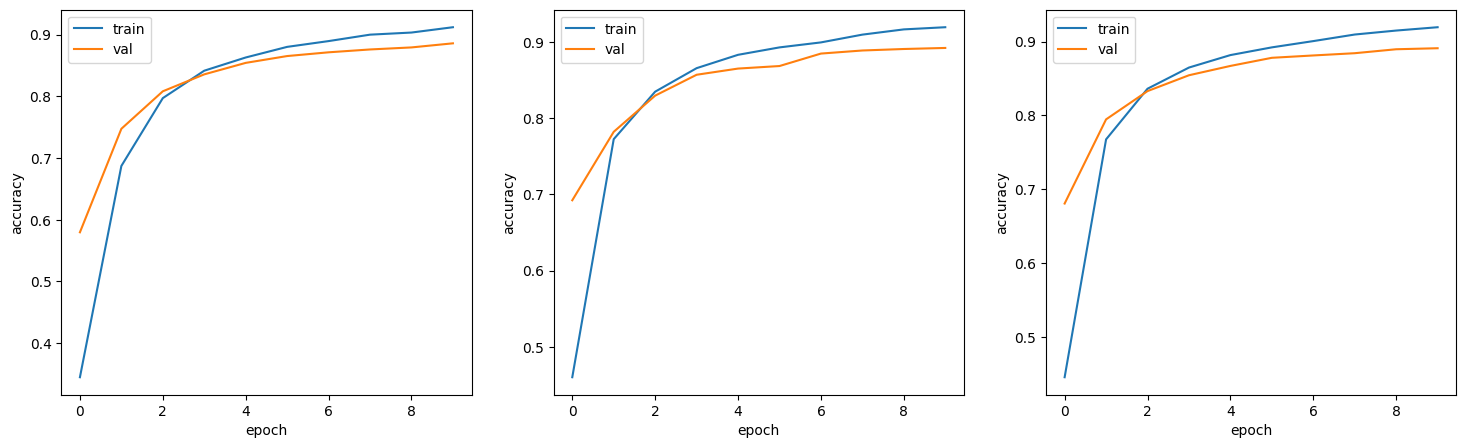

In [52]:
# importlib.reload(POS_utility)
POS_utility.plot_single_runs(seq_baseline_hist)

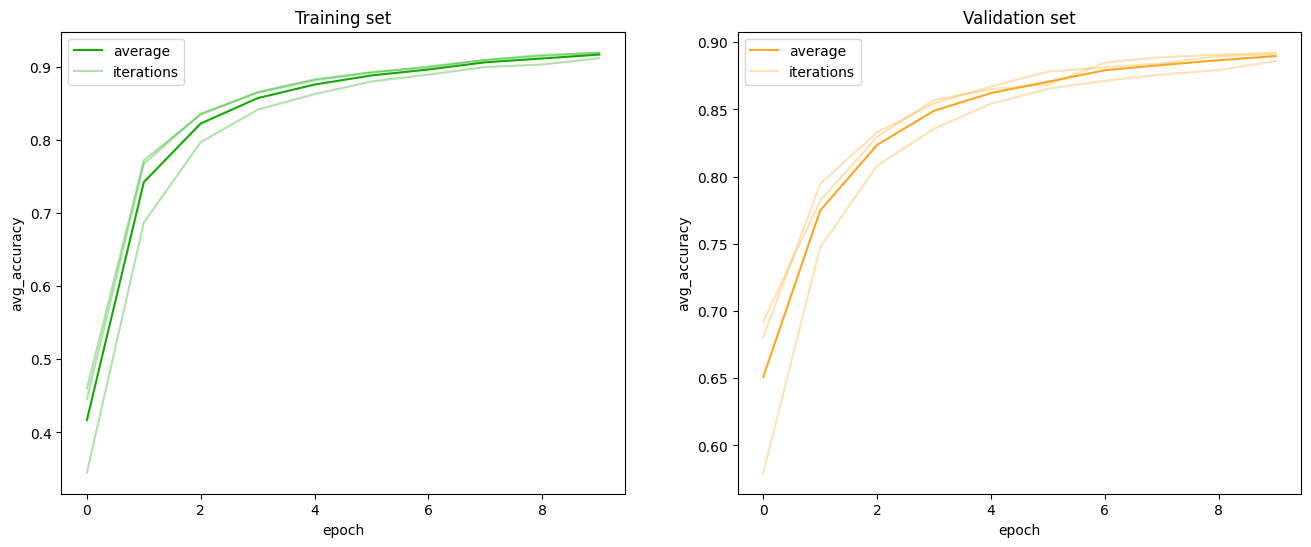

In [53]:
POS_utility.plot_averages(seq_baseline_hist)